In [63]:
## Simulation for unwrapping error correction with bridging
## useful skimage functions: http://scikit-image.org/docs/stable/auto_examples/index.html
# link: http://scikit-image.org/docs/stable/auto_examples/segmentation/plot_label.html
# http://scikit-image.org/docs/stable/api/skimage.segmentation.html#relabel-sequential
# http://scikit-image.org/docs/stable/api/skimage.measure.html#regionprops
# http://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.profile_line
# http://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label
# 

import os
import sys
import pickle
import numpy as np
import random
from matplotlib import pyplot as plt
from skimage.draw import bezier_curve
from skimage.morphology import erosion
from skimage.measure import label
from pysar.simulation.plot import *
from pysar.simulation import simulation as sim, fractal
from pysar.objects import timeseries, ifgramStack, sensor, giantTimeseries
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut, network as pnet

work_dir = os.path.expanduser('~/development/python/2018_ComputGeosci_PySAR/sim_bridging')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

# ref attributes
ref_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
ref_file = os.path.join(ref_dir, 'timeseries.h5')
atr = readfile.read_attribute(ref_file)
L = int(atr['ALOOKS']) * int(atr['RLOOKS'])
range2phase = -4. * np.pi / float(atr['WAVELENGTH'])
resolution = ut.range_ground_resolution(atr)
source_geom = (30 * resolution, 75 * resolution, 2e3, 1e6)  #Mogi (east, north, depth, vol change)

# configure
shape = (100, 100) # size in (length, width) in pixel number
length, width = shape
ref_x, ref_y = int(0.95*width), int(0.95*length)

# update atr
atr['LENGTH'] = length
atr['WIDTH'] = width
atr['REF_Y'] = ref_y
atr['REF_X'] = ref_x

# output file
sim_int_file = os.path.join(work_dir, 'sim.int')
sim_cor_file = os.path.join(work_dir, 'sim.cor')
sim_unw_file = os.path.join(work_dir, 'sim.unw')

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/sim_bridging


simulating interferometric phase and coherence ...
write to file /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/sim_bridging/sim.int
write to file /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/sim_bridging/sim.cor


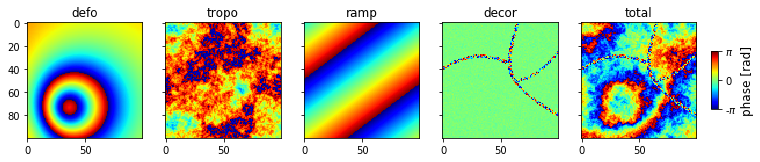

In [67]:
# simulate interferometric phase
if not os.path.isfile(sim_int_file):
    print('simulating interferometric phase and coherence ...')
    # 1. simulate deformation from Mogi source
    defo = sim.mogi_deformation(shape, source_geom, resolution=resolution, display=False)
    defo *= range2phase
    defo -= defo[ref_y, ref_x]
    
    # 2. simulate tropospheric turbulence
    trop = fractal.fractal_surface_atmos(shape=shape, resolution=resolution, p0=1e-3)
    trop *= range2phase
    trop -= trop[ref_y, ref_x]
    
    # 3. ramp
    xx, yy = np.meshgrid(np.arange(0, width), np.arange(0, length))
    ramp = (xx * 0.03 + yy * 0.04) * 2.0
    ramp -= ramp[ref_y, ref_x]

    # 4. decorrelation noise
    mask = np.ones(shape)
    # generate decorrelated boundaries
    rr, cc = bezier_curve(int(0.0 *length),int(0.65*width), int(0.50*length),int(0.50*width), int(0.80*length),int(1.00*width),weight=2,shape=shape); mask[rr,cc] = 0
    rr, cc = bezier_curve(int(0.40*length),int(0.0 *width), int(0.20*length),int(0.30*width), int(0.35*length),int(0.57*width),weight=1,shape=shape); mask[rr,cc] = 0
    rr, cc = bezier_curve(int(0.50*length),int(0.62*width), int(0.50*length),int(0.80*width), int(0.25*length),int(1.00*width),weight=1,shape=shape); mask[rr,cc] = 0
    # expand the boundaries
    mask = erosion(mask)
    # simulate decorrelation noise
    coh = np.zeros(shape, np.float32)
    decor = np.zeros(shape)
    for flag, cor in zip([0, 1], [0.01, 0.7]):
        mask0 = mask == flag
        decor0 = sim.sample_decorrelation_phase(L, cor, size=length*width).reshape(length, width)
        decor[mask0] = decor0[mask0]
        coh[mask0] = cor
    decor -= decor[ref_y, ref_x]

    # 5. sum up
    ifg_sim = defo + trop + ramp + decor
    ifg_sim = np.array(ifg_sim, np.float32)

    # write to file
    print('write to file', sim_int_file)
    writefile.write(ifg_sim, sim_int_file, atr)
    print('write to file', sim_cor_file)
    writefile.write(coh, sim_cor_file, atr)

    # plot
    labels = ['defo', 'tropo', 'ramp', 'decor', 'total']
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=[10, 2], sharey=True)
    for i, data, label in zip(range(len(labels)), [defo, trop, ramp, decor, ifg_sim], labels):
        ax = axs[i]
        im = ax.imshow(ut.wrap(data), cmap='jet', vmin=-np.pi, vmax=np.pi)
        ax.set_title(label)
    fig.subplots_adjust(left=0.02, right=0.95, bottom=0.02, top=0.98)
    # colorbar
    cax = fig.add_axes([0.97, 0.3, 0.01, 0.4])
    cbar = plt.colorbar(im, cax=cax, ticks=[-np.pi, 0, np.pi])
    cbar.ax.set_yticklabels([r'-$\pi$', '0', r'$\pi$'])
    cbar.set_label('phase [rad]', fontsize=font_size)
    plt.show()

else:
    print('read exsiting interferogram')
    


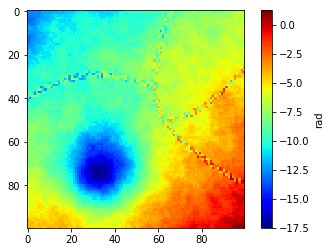

In [58]:
# 5. sum up
#ifg_unw = dis*range2phase + trop*range2phase + decor
##ifg_unw = dis*range2phase + decor
#ifg_int = ut.wrap(ifg_unw)
#
#fig, axs = plt.subplots(nrows=1, ncols=2)#, figsize=[8, 3])
#axs[0].imshow(coh, cmap='gray', vmin=0, vmax=1); axs[0].set_title('spatial coherence')
#axs[1].imshow(ifg_int, cmap='jet', vmin=-np.pi, vmax=np.pi); axs[1].set_title('wrapped phase')
#plt.show()

plt.figure()
plt.imshow(ifg_sim, cmap='jet')
plt.colorbar(label='rad')
plt.show()

In [14]:
import isce
from contrib.Snaphu.Snaphu import Snaphu

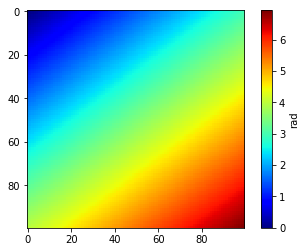

In [36]:
xx, yy = np.meshgrid(np.arange(0, width),
                     np.arange(0, length))
ramp = xx * 0.03 + yy * 0.04
plt.figure()
plt.imshow(ramp*0.1, cmap='jet')
plt.colorbar(label='rad')
plt.show()

In [62]:
# metadata for unwrap with snaphu
config = {}
config['wavelength'] = float(atr['WAVELENGTH'])
config['altitude'] = float(atr['altitude'])
config['earthRadius'] = float(atr['earthRadius'])
config['rglooks'] = int(atr['RLOOKS'])
config['azlooks'] = int(atr['ALOOKS'])
config['corrlooks'] = config['rglooks'] * config['rglooks'] / (0.8 * 0.8)

In [61]:
atr['altitude']

'698936.9951860035'